In [1]:
import env
import numpy as np
import agents_gpu as agent
import copy
import torch as tr
from torch import nn
from matplotlib import pyplot as plt

C:\Users\NiSz\Anaconda3\envs\ml\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loss graphs

In [29]:
Exlosses, Exreward = np.load("ExToM.npy", allow_pickle = True)
Exloss_Policy = np.array(Exlosses[:2])
Exloss_ToM = np.array(Exlosses[2:])

Nolosses, Noreward = np.load("NoExToM.npy", allow_pickle = True)
Noloss_Policy = np.array(Nolosses[:2])
Noloss_ToM = np.array(Nolosses[2:])

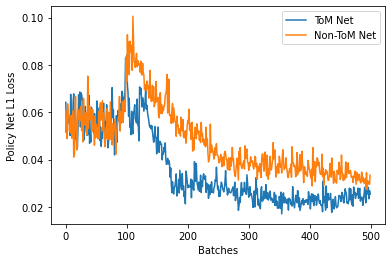

In [75]:
plt.figure()
plt.plot(np.mean(Exloss_Policy, 0).reshape([500, 10]).mean(1))
plt.plot(np.mean(Noloss_Policy, 0).reshape([500, 10]).mean(1))
plt.legend(["ToM Net", "Non-ToM Net"])
plt.ylabel("Policy Net L1 Loss")
plt.xlabel("Batches")
plt.savefig("1.svg")

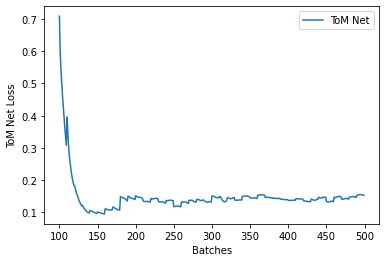

In [76]:
plt.figure()
plt.plot(range(100, 500), np.mean(Exloss_ToM, 0).reshape([400, 10]).mean(1))
plt.legend(["ToM Net", "Non-ToM Net"])
plt.ylabel("ToM Net Loss")
plt.xlabel("Batches")
plt.savefig("1.1.svg")

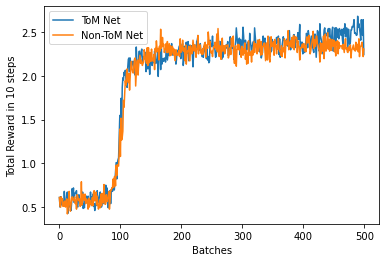

In [36]:
plt.figure()
plt.plot(np.sum(Exreward, 1))
plt.plot(np.sum(Noreward, 1))
plt.legend(["ToM Net", "Non-ToM Net"])
plt.ylabel("Total Reward in 10 steps")
plt.xlabel("Batches")
plt.savefig("2.svg")

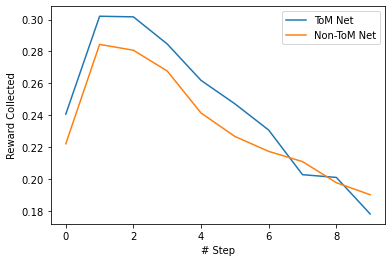

In [37]:
plt.figure()
plt.plot(np.mean(Exreward[-100:], 0))
plt.plot(np.mean(Noreward[-100:], 0))
plt.legend(["ToM Net", "Non-ToM Net"])
plt.ylabel("Reward Collected")
plt.xlabel("# Step")
plt.savefig("3.svg")

# ToM in a sample environment

In [39]:
sample_env = env.GridWorld(size = 11, n_target = 4)
sample_env.init_state["world"][:,:,0] = np.array([
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
[1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
])
sample_env.init_state["world"][:,:,1] = np.array([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
])
sample_env.init_state["agents"][:,:,0] = np.array([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
])
sample_env.init_state["agents"][:,:,1] = np.array([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
])
sample_env.reset();
print(sample_env)
print("#: wall, r: target, 1 & 2: agents")

  # # # # # # # # # # # 
  #     #             # 
  #   r #             # 
  #                   # 
  #                 1 # 
  #                   # 
  #                 2 # 
  #                   # 
  #       # # #       # 
  #             r     # 
  # # # # # # # # # # #  
#: wall, r: target, 1 & 2: agents


C:\Users\NiSz\AppData\Local\Temp/ipykernel_28024/2804600076.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.imshow(sample_agent.ToMNet(tr.tensor(obs).float().cuda()).cpu().detach().numpy()[0,:,:], cmap = "Greys")


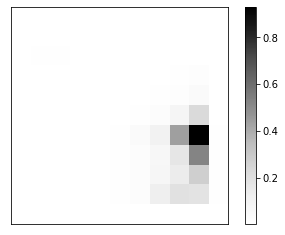

In [69]:
# ToM output example
obs = sample_env.observe()[0]
obs = tr.tensor([obs.transpose([2, 0, 1])[[0, 1, 3],:,:]]).float().cuda()

sample_agent = agent.ExToMAgent(lr = 0.01, obs_shape = (11, 11, 4))
sample_agent.load_models("PolicyNet_dict_ExToM", "ToMNet_dict")

plt.imshow(sample_agent.ToMNet(tr.tensor(obs).float().cuda()).cpu().detach().numpy()[0,:,:], cmap = "Greys")
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
plt.savefig("4.svg")

In [58]:
help(cbar.set_label)

Help on method set_label in module matplotlib.colorbar:

set_label(label, *, loc=None, **kwargs) method of matplotlib.colorbar.Colorbar instance
    Add a label to the long axis of the colorbar.
    
    Parameters
    ----------
    label : str
        The label text.
    loc : str, optional
        The location of the label.
    
        - For horizontal orientation one of {'left', 'center', 'right'}
        - For vertical orientation one of {'bottom', 'center', 'top'}
    
        Defaults to :rc:`xaxis.labellocation` or :rc:`yaxis.labellocation`
        depending on the orientation.
    **kwargs
        Keyword arguments are passed to `~.Axes.set_xlabel` /
        `~.Axes.set_ylabel`.
        Supported keywords are *labelpad* and `.Text` properties.

